# Baseline Model

Our Baseline Model is a one-layer CNN.

##Preparation Part

In [1]:
# Import Libraries
import numpy as np
import time
import os
# Import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
# Import torch vision
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
# Import plot
import matplotlib.pyplot as plt

In [2]:
# Access Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# CUDA and GPU 
!nvidia-smi
use_cuda = True

Fri Apr  1 17:28:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Dataset Loading Part

In [4]:
from torchvision.transforms.transforms import Resize
# DIfferent directories
jeff_dir = '/content/gdrive/MyDrive/APS360-Project/Dataset_3/'
charlie_dir = '/content/gdrive/MyDrive/ECE/2022Winter/APS360/Dataset/'
# Choose directory
data_dir = charlie_dir

train_dir = os.path.join(data_dir, 'train/')
val_dir = os.path.join(data_dir, 'validation/')
test_dir = os.path.join(data_dir, 'test/')

classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

transform = transforms.Compose([transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform = transform)
val_data = datasets.ImageFolder(val_dir, transform = transform)
test_data = datasets.ImageFolder(test_dir, transform = transform)

print('Number of training images: ', len(train_data))
print('Number of validation images: ', len(val_data))
print('Number of testting images: ', len(test_data))


Number of training images:  21011
Number of validation images:  4504
Number of testting images:  4494


In [5]:
def data_loader(train_data, val_data, test_data, batch_size, num_workers = 1):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
    return train_loader, val_loader, test_loader;

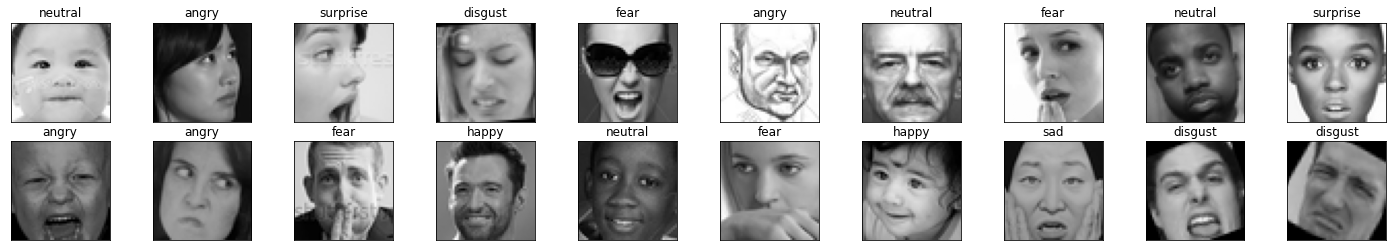

In [6]:
batch_size = 64
train_loader, val_loader, test_loader = data_loader(train_data, val_data, test_data, batch_size)
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

##Neural Network Part

In [7]:
# Baseline Model Architecture
class baseline_model(nn.Module):
    def __init__(self):
        super(baseline_model, self).__init__()
        self.name = "baseline"
        # looking for a three-channel input
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(9 * 9 * 20, 32)
        self.fc2 = nn.Linear(32, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 9 * 9 * 20) # flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
# Train function 
def train(model, train_loader, val_loader, batch_size=256, learning_rate=0.001, num_epochs=20):
  # Random Seed
  torch.manual_seed(10)

  # Criterion and Optimizer Choice
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  # Initialization
  iters, losses, train_acc, val_acc = np.zeros(num_epochs), np.zeros(num_epochs), np.zeros(num_epochs), np.zeros(num_epochs)

  # training 
  iterations = 0 

  n=0
  start_time = time.time()
  for epoch in range(num_epochs):
      for imgs, labels in iter(train_loader): 
          #############################################
          #To Enable GPU Usage
          if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
          #############################################
          
          out = model(imgs)                       # forward pass 
          loss = criterion(out, labels)           # compute the total loss 
          loss.backward()
          optimizer.step()                        # backward pass (compute para. update) 
          optimizer.zero_grad()                   # a clean up step for PyTorch 
          n += 1
          # print("Iteration: ",n, "Time Elapsed: % 6.2f s " % (time.time()-start_time))
        
      ##############################################################
      # save the current training info. 
      iters[epoch] = iterations
      losses[epoch] = float(loss)/batch_size

      train_acc[epoch] = get_accuracy(model, train_loader)
      val_acc[epoch] = get_accuracy(model, val_loader)

      print("epoch number", epoch+1, ". Training accuracy:",train_acc[epoch] , ". Validation accuracy:",val_acc[epoch], 
            ". Training loss:", losses[epoch], ". Epoch took % 6.2f s" % (time.time() - start_time))
      iterations += 1

  # save models for later usage
  model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, num_epochs)
  torch.save(model.state_dict(), model_path)
  
  end_time = time.time()
  print("Total time elapsed: % 6.2f s" % (end_time - start_time))
  # plotting 
  plt.title ('Training Curve')
  plt.plot(iters, losses, label='Train')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.show()

  plt.title("Training Curve")
  plt.plot(iters, train_acc, label='Train')
  plt.plot(iters, val_acc, label='Validation')
  plt.xlabel('Iterations')
  plt.ylabel('Accuracy')
  plt.legend(loc='best')
  plt.show() 
  
  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print('Final Validation Accuracy: {}'.format(val_acc[-1]))


##Helper Functional Part

In [26]:
# Get Accuracy
def get_accuracy(model, data_loader):
    # Initialization
    correct, total = 0, 0

    # Accuracy train loop
    for imgs, labels in data_loader:
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()

        output = model(imgs)
        predict = output.max(1, keepdim=True)[1]
        correct += predict.eq(labels.view_as(predict)).sum().item()
        total += imgs.shape[0]

    return correct / total

##Main Operations Part

CUDA is available...
epoch number 1 . Training accuracy: 0.25895959259435536 . Validation accuracy: 0.22646536412078153 . Training loss: 0.006800011731684208 . Epoch took  2192.34 s
epoch number 2 . Training accuracy: 0.2584836514206844 . Validation accuracy: 0.2644316163410302 . Training loss: 0.006388209294527769 . Epoch took  2252.17 s
epoch number 3 . Training accuracy: 0.24915520441673408 . Validation accuracy: 0.2617673179396092 . Training loss: 0.005692376755177975 . Epoch took  2312.09 s
epoch number 4 . Training accuracy: 0.25619913378706394 . Validation accuracy: 0.23157193605683837 . Training loss: 0.0070097483694553375 . Epoch took  2371.34 s
epoch number 5 . Training accuracy: 0.25515206320498784 . Validation accuracy: 0.2289076376554174 . Training loss: 0.006727718282490969 . Epoch took  2430.51 s
epoch number 6 . Training accuracy: 0.24458616914949313 . Validation accuracy: 0.24600355239786856 . Training loss: 0.007302899844944477 . Epoch took  2489.74 s
epoch number 7 .

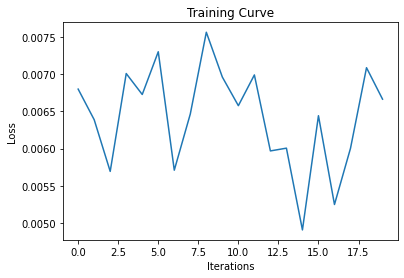

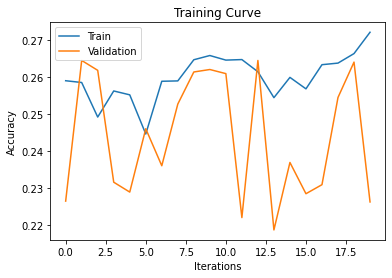

Final Training Accuracy: 0.272047974870306
Final Validation Accuracy: 0.22624333925399645


In [ ]:
# Model 1
model = baseline_model()

# Use CUDA
if use_cuda and torch.cuda.is_available:
    model.cuda()
    print('CUDA is available...')

train(model, train_loader, val_loader, batch_size=256, learning_rate=3e-2, num_epochs=20)

CUDA is available...
epoch number 1 . Training accuracy: 0.1427823521012803 . Validation accuracy: 0.14253996447602132 . Training loss: 0.0038015497848391533 . Epoch took  4841.92 s
epoch number 2 . Training accuracy: 0.1427823521012803 . Validation accuracy: 0.14253996447602132 . Training loss: 0.003835129551589489 . Epoch took  4900.32 s
epoch number 3 . Training accuracy: 0.1433058873923183 . Validation accuracy: 0.14253996447602132 . Training loss: 0.003747527254745364 . Epoch took  4958.80 s
epoch number 4 . Training accuracy: 0.1427823521012803 . Validation accuracy: 0.14253996447602132 . Training loss: 0.003960002213716507 . Epoch took  5017.19 s
epoch number 5 . Training accuracy: 0.1427823521012803 . Validation accuracy: 0.14253996447602132 . Training loss: 0.004014647100120783 . Epoch took  5076.08 s
epoch number 6 . Training accuracy: 0.1427823521012803 . Validation accuracy: 0.14253996447602132 . Training loss: 0.00392063707113266 . Epoch took  5137.60 s
epoch number 7 . Tr

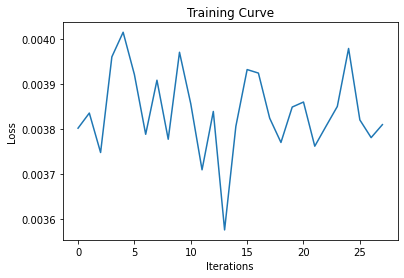

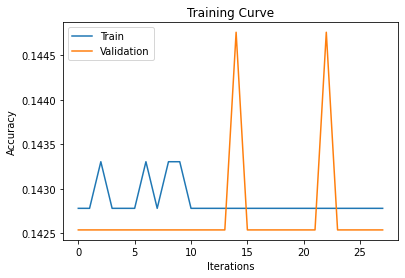

Final Training Accuracy: 0.1427823521012803
Final Validation Accuracy: 0.14253996447602132


In [ ]:
# Model 2
model = baseline_model()

# Use CUDA
if use_cuda and torch.cuda.is_available:
    model.cuda()
    print('CUDA is available...')

train(model, train_loader, val_loader, batch_size=512, learning_rate=3e-1, num_epochs=28)

In [ ]:
# Model 3
model = baseline_model()

# Use CUDA
if use_cuda and torch.cuda.is_available:
    model.cuda()
    print('CUDA is available...')

train(model, train_loader, val_loader, batch_size=256, learning_rate=5e-3, num_epochs=18)

In [ ]:
# Model 4
model = baseline_model()

# Use CUDA
if use_cuda and torch.cuda.is_available:
    model.cuda()
    print('CUDA is available...')

train(model, train_loader, val_loader, batch_size=128, learning_rate=3e-4, num_epochs=18)

CUDA is available...
epoch number 1 . Training accuracy: 0.1649612107943458 . Validation accuracy: 0.1625222024866785 . Training loss: 0.030064187943935394 . Epoch took  706.44 s
epoch number 2 . Training accuracy: 0.20474989291323592 . Validation accuracy: 0.20159857904085257 . Training loss: 0.030233891680836678 . Epoch took  771.36 s
epoch number 3 . Training accuracy: 0.2854219218504593 . Validation accuracy: 0.27175843694493784 . Training loss: 0.029719118028879166 . Epoch took  835.39 s
epoch number 4 . Training accuracy: 0.285802674789396 . Validation accuracy: 0.272202486678508 . Training loss: 0.02956559509038925 . Epoch took  899.25 s
epoch number 5 . Training accuracy: 0.31616772166960166 . Validation accuracy: 0.30683836589698044 . Training loss: 0.028420526534318924 . Epoch took  962.47 s
epoch number 6 . Training accuracy: 0.3244015039741088 . Validation accuracy: 0.32393428063943164 . Training loss: 0.03037099540233612 . Epoch took  1026.63 s
epoch number 7 . Training ac

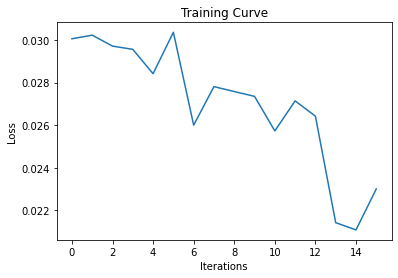

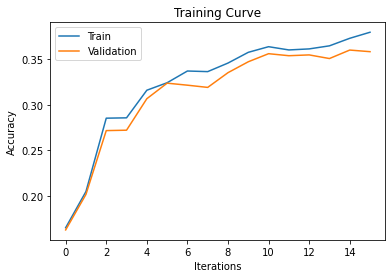

Final Training Accuracy: 0.37994383894150685
Final Validation Accuracy: 0.3585701598579041


In [17]:
# Model 6
model = baseline_model()

# Use CUDA
if use_cuda and torch.cuda.is_available:
    model.cuda()
    print('CUDA is available...')

train(model, train_loader, val_loader, batch_size=64, learning_rate=2e-5, num_epochs=16)

In [27]:
# Best model
best_model = baseline_model()

# Use CUDA
if use_cuda and torch.cuda.is_available:
    best_model.cuda()
    print('CUDA is available...')

best_model_path = 'model_{}_bs{}_lr{}_epoch{}'.format('baseline', 64, 2e-5, 16)

# Load saved best model
best_model.load_state_dict(torch.load(best_model_path))

# Test Accuracy of the best Model
get_accuracy(best_model, test_loader)

CUDA is available...


0.36092567868268804

# Visualise Part

Visualise the feature map of the model

In [13]:
# save the conv layer weights in this list
model_weights =[]
# save the conv layers in this list
conv_layers = []

# get all the model children as list
model = baseline_model()
model_children = list(model.children())

#counter to keep count of the conv layers
counter = 0

#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)

print(f"Total convolution layers: {counter}")
print("conv_layers")


Total convolution layers: 2
conv_layers


In [ ]:
# Generate feature maps
outputs = []
names = []

for image, label in iter(test_loader):
  for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
  break

print(len(outputs))

# Print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

# Convert 3D tensor to 2D
# Sum the same element of every channel
processed = []

for feature_map in outputs:
    feature_map = feature_map.squeeze()
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())

for fm in processed:
    print(fm.shape)

# Plot feature maps and save
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')